# Quickstart: Survey

learn how to generate a survey

In [1]:
from skysurvey import survey

/Users/rigault/miniforge3/lib/python3.9/site-packages/ztfquery-1.19.0-py3.9.egg/ztfquery/utils/tools.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([v[0]*np.cos(theta*_DEG2RA) - v[2]*np.sin(theta*_DEG2RA),


let's start with two predefined survey. A generic HealpixSurvey (based on healpix sky segmentation) 
and a real one ZTF (based on polygon sky segmentation)

### Healpix Survey

In [2]:
hpsurvey = survey.HealpixSurvey(9)

Let's draw the equivalent of 4 years of observations assuming 1000 healpix pixel pointings per day

Remark that, as such mjd_range and size are drawn independenly so, 1000 pointing per day is an average. 

In [3]:
%%time
hpsurvey.draw_random(size=365*4*1000, # number of observation 
                     bands=["ztf:g","ztf:r","ztf:i"], # band to observed
                     mjd_range=[56000, 56000+365*4], # timerange of observation
                     skynoise_range=[180,210], # sky noise
                     ra_range=[-30,90], 
                    inplace=True)  # set the self.data and do not return a new HealpixSurvey

CPU times: user 1.43 s, sys: 127 ms, total: 1.56 s
Wall time: 1.57 s


Remark: you could have load it directly this way using the ``from_random`` classmethod

In [4]:
%%time
hpsurvey = survey.HealpixSurvey.from_random(nside=9, 
                                     size=365*4*1000, # number of observation 
                                     bands=["ztf:g","ztf:r","ztf:i"],
                                     mjd_range=[56000, 56000+365*4], 
                                     skynoise_range=[180,210], 
                                     ra_range=[-30,90])

CPU times: user 1.58 s, sys: 88.6 ms, total: 1.67 s
Wall time: 1.67 s


In [5]:
hpsurvey.data # Show the data generated. time, band sky noise, gain, zp and fieldid.

,index,mjd,band,skynoise,gain,zp,fieldid
0,1376732,56000.002833,ztf:r,199.988260,1.0,25.0,582
1,1233282,56000.003534,ztf:i,207.353659,1.0,25.0,41
2,46602,56000.004359,ztf:i,181.503385,1.0,25.0,270
3,725227,56000.006909,ztf:i,186.936721,1.0,25.0,87
4,258599,56000.007750,ztf:g,204.752454,1.0,25.0,82
...,...,...,...,...,...,...,...
1459995,891576,57459.992057,ztf:g,207.086858,1.0,25.0,159
1459996,21047,57459.992484,ztf:r,180.078056,1.0,25.0,343
1459997,40775,57459.993943,ztf:r,191.445406,1.0,25.0,284
1459998,1133746,57459.995424,ztf:r,186.317511,1.0,25.0,656


Let's get the number of time a 'field' has been observed

In [6]:
hpsurvey.get_fieldstat("size") 

323    2168
538    2158
436    2153
624    2153
131    2146
       ... 
290    1915
696    1914
34     1912
476    1905
565    1869
Name: fieldid, Length: 720, dtype: int64

These are just short cut to pandas dataframe contained in self.data

So you can play.

Let's measure the number of observation we have per day and per band

In [7]:
data = hpsurvey.data.copy()
data["day"] = data["mjd"].astype(int)

In [8]:
dailybands = data.groupby(["day","band"]).size()
dailybands

day    band 
56000  ztf:g    311
       ztf:i    333
       ztf:r    349
56001  ztf:g    353
       ztf:i    322
               ... 
57458  ztf:i    299
       ztf:r    337
57459  ztf:g    333
       ztf:i    319
       ztf:r    328
Length: 4380, dtype: int64

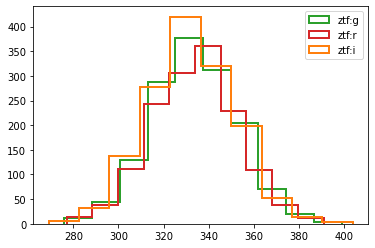

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot()

prop = dict(lw=2, histtype="step")
ax.hist(dailybands.xs("ztf:g", level=1), color="tab:green", label="ztf:g", **prop) 
ax.hist(dailybands.xs("ztf:r", level=1), color="tab:red", label="ztf:r",**prop)
ax.hist(dailybands.xs("ztf:i", level=1), color="tab:orange", label="ztf:i",**prop)
ax.legend(loc='best')

#### Get the field of a target

This is an important feature that enable us to know whic field contains which target

In [10]:
hpsurvey.radec_to_fieldid(40, 90)

189

In [11]:
import numpy as np
# remark that, doing that this way, it won't be homogeneous.
ra_flat = np.random.uniform(-30, 90, 1000)
dec_flat = np.random.uniform(0, 360, 1000)
hpsurvey.radec_to_fieldid(ra_flat, dec_flat)

array([554, 648,   3, 133, 165,  35, 177, 402, 388,  93,  45, 673, 577,
       572, 629,   1,   5, 211, 453, 379, 116, 106,  66, 257, 305, 234,
        78, 482,  58, 442, 557, 165, 271, 448, 634, 195,  10, 510, 563,
       328, 315, 299, 659,   2, 318,   9, 218, 105, 450, 162,  18,   7,
       404,  75, 502, 236,  58, 111, 143,  38,   6, 442, 667, 676, 372,
       347, 366,  40,   1, 701, 254,  44, 560, 353, 491, 119, 740,   4,
        84, 624, 537, 276, 503, 282, 201, 185,  63, 596, 530, 715, 608,
       139, 135, 509, 552, 459, 262,   2,  44, 223,  13, 217, 322, 630,
       443, 145, 699,   3, 578,  10, 383,   1, 599,  44,  10, 316,   9,
        43, 391, 658,  66, 146,   2, 703,   0,  48,  53, 108,   3, 628,
       352,  77, 159, 686, 563,   1, 471,  20, 422, 547,  90,  12,  59,
       341, 162, 193,  42, 408, 220,  12, 455, 135, 105,  39, 381, 373,
       151,   3,  39, 270, 451, 362, 277, 171, 439, 421, 150, 452, 126,
       607, 628, 641, 614,   9,   3, 103, 287,  82,  32, 195, 28

### ZTF, a polygon survey

polygon survey are surveys which pointings are defined by a (potentially very long) list of fieldid. (see self.

In [12]:
from skysurvey.survey import ZTF

random is using the real ZTF field definition, but enables you to generate a random draw (unrealistic) as for HealpixSurvey

In [13]:
%%time
ztf = ZTF.from_random(size=365*4*1000, # number of observation 
                     bands=["ztf:g","ztf:r","ztf:i"], # band to observed
                     mjd_range=[56000, 56000+365*4], # timerange of observation
                     skynoise_range=[180,210], # sky noise
                     )

CPU times: user 1.56 s, sys: 74.1 ms, total: 1.64 s
Wall time: 1.65 s


If you have a list of observation have these data. load directly a ztf instance with that

In [14]:
%%time
other_ztf = ZTF(data=data)

CPU times: user 34 ms, sys: 8.7 ms, total: 42.7 ms
Wall time: 38.6 ms


In [15]:
other_ztf.get_fieldstat("size")

323    2168
538    2158
436    2153
624    2153
131    2146
       ... 
290    1915
696    1914
34     1912
476    1905
565    1869
Name: fieldid, Length: 720, dtype: int64

**Next let's join targets and survey**